[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/comp-hci-lab/BDSI_2021_ML/blob/master/A1%20-%20Decision%20Boundary.ipynb)

## BDSI ML 2021

# A1 - Neural Nets: Decision Boundary (demo)
- Two synthetic datasets in 2D
- Visualize the decision boundary and output contour of single-layer or multi-layer neural nets

Similar visualizations can be found at: https://playground.tensorflow.org/

In [1]:
# GPU support
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cpu


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['lines.markersize'] = 6.0

In [4]:
#@title Helper functions for plotting. { display-mode: "form" }
from matplotlib import cm, ticker

MARKERS = ['o', 'x', 'v']
COLORS = ['red', 'green', 'blue']

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_points(X, y):
    for i, label in enumerate(set(y)):
        points = X[y == label]
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

def predict(model, x):
    with torch.no_grad():
        o = model(torch.from_numpy(x).float().to(device))
    return o.cpu().numpy()

def plot_boundary(X, pred):
    try:
        x_min, x_max = plt.gca().get_xlim()
        y_min, y_max = plt.gca().get_ylim()
    except:
        x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
        y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)
    plt.contour(xs, ys, (zs >= 0.5).astype(int), cmap='Greys')
    plt.imshow(zs, cmap="PiYG", vmin=-.2, vmax=1.2, alpha=0.4, origin='lower', extent=[x_min, x_max, y_min, y_max])

In [5]:
#@title Two synthetic datasets in 2D. { display-mode: "form" }
from torch.utils.data import Dataset, DataLoader

class D1(Dataset):
    def __init__(self, N=50):
        super().__init__()
        np.random.seed(0)
        self.X = np.r_[2.0 * np.random.randn(N//2, 2) - [2, 2], 2.0 * np.random.randn(N//2, 2) + [2, 2]]
        self.y = np.array([0] * (N//2) + [1] * (N//2))
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.FloatTensor([self.y[idx]])
    
    def __len__(self):
        return len(self.X)

class D2(Dataset):
    def __init__(self, N=50):
        super().__init__()
        np.random.seed(0)
        X = 2.0 * np.random.randn(N, 2)
        y = np.array([0] * N)
        y[np.diag(X@X.T)>6] = 1
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.FloatTensor([self.y[idx]])
    
    def __len__(self):
        return len(self.X)

## Load data
Try `d = D1(100)` or `d = D2(100)`

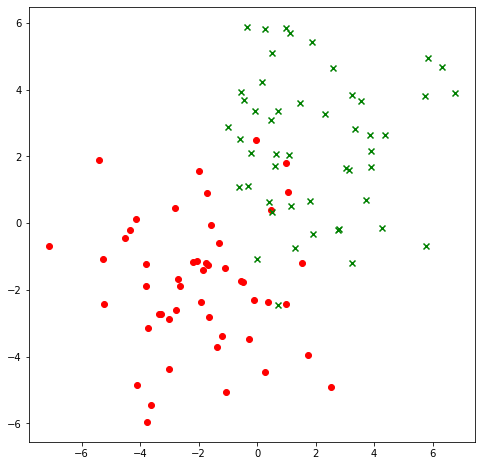

In [6]:
d = D1(100)
plot_points(d.X, d.y)

## Define the neural network:

In [7]:
torch.random.manual_seed(2)
net = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid(),
)
net.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
dataloader = DataLoader(d, batch_size=4)

In [8]:
print('Number of float-valued parameters:', count_parameters(net))

Number of float-valued parameters: 3


## Before training...

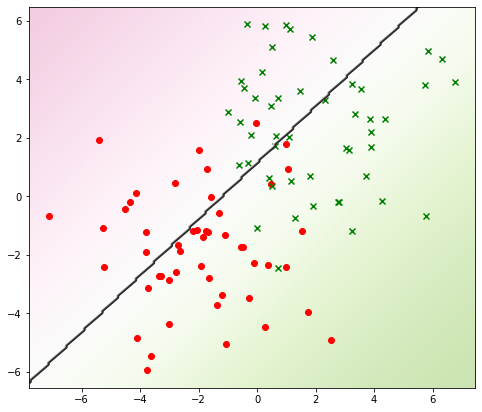

In [9]:
plot_points(d.X, d.y)
plot_boundary(d.X, lambda x: predict(net, x))

## After training...

In [10]:
# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = net(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step() 

100%|██████████| 1000/1000 [00:05<00:00, 171.61it/s]


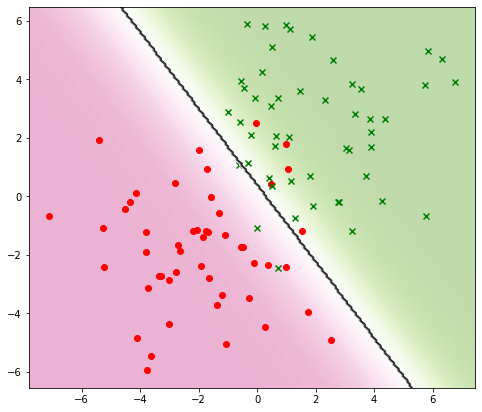

In [11]:
plot_points(d.X, d.y)
plot_boundary(d.X, lambda x: predict(net, x))